### NLP Project - SNLI Corpus

#### This project will focus on the task of classifying sentence pairs from the SNLI sentence similarity corpus into three categories: entailment, contradiction, or neutral.

#### Entailment means that the second sentence follows from the first. Contradiction means that the second sentence contradicts the first. Neutral is the case where there is neither entailment nor contradiction.

#### I will be trying three different deep learning models for this task. For NLP tasks such as this, deep neural networks produce cutting edge results.

#### Model 0 will be the baseline, a simple model consisting of stacked LSTM layers.

#### Model 1 will be an attention network model based on the following paper: https://arxiv.org/pdf/1606.01933.pdf . I will largely be using the same parameters as described in the paper.

#### Model 2 will be the ESIM model based on the following paper: https://arxiv.org/pdf/1609.06038v3.pdf

### Section 1: Preparation

First, I load the necessary libraries for the project, and load the SNLI train data into a pandas dataframe.

In [1]:
import zipfile
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename,'r')
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
unzip_data("snli_1.0.zip")

In [3]:
with open('snli_1.0/snli_1.0/snli_1.0_train.jsonl') as data:
  lines = data.read().splitlines()
  line_dicts = [json.loads(line) for line in lines]
  df = pd.DataFrame(line_dicts)

In [4]:
df.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],3416050480.jpg#4,neutral,3416050480.jpg#4r1n,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,A person is training his horse for a competition.,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
1,[contradiction],3416050480.jpg#4,contradiction,3416050480.jpg#4r1c,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is at a diner, ordering an omelette.",( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
2,[entailment],3416050480.jpg#4,entailment,3416050480.jpg#4r1e,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is outdoors, on a horse.","( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
3,[neutral],2267923837.jpg#2,neutral,2267923837.jpg#2r1n,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,They are smiling at their parents,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...
4,[entailment],2267923837.jpg#2,entailment,2267923837.jpg#2r1e,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,There are children present,( There ( ( are children ) present ) ),(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...


In [6]:
df.shape

(550152, 10)

I decided to remove all entries without a gold label as follows:

In [7]:
df['gold_label'].value_counts()

entailment       183416
contradiction    183187
neutral          182764
-                   785
Name: gold_label, dtype: int64

In [8]:
df = df[df.gold_label != '-']

In [9]:
df_text = df[["gold_label","sentence1","sentence2"]]

In [10]:
df_text['label'] = df_text['gold_label'].apply(lambda x: 2 if x=="entailment" else 1 if x=="neutral" else 0)

C:\Users\nickj\AppData\Local\Temp\ipykernel_7016\4003425532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['label'] = df_text['gold_label'].apply(lambda x: 2 if x=="entailment" else 1 if x=="neutral" else 0)


In [11]:
df_text.head()

,gold_label,sentence1,sentence2,label
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",2
3,neutral,Children smiling and waving at camera,They are smiling at their parents,1
4,entailment,Children smiling and waving at camera,There are children present,2


In [12]:
df_text = df_text.sample(frac=1)

Here, I use numpy to create seperate structures for the train data and the labels, one-hot encoded so that they are compatible with Tensorflow.

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
onehot = OneHotEncoder(sparse_output=False)

In [15]:
train_pairs = df_text[['sentence1','sentence2']].to_numpy().astype('str')
train_labels_one_hot = onehot.fit_transform(df_text['label'].to_numpy().reshape(-1,1))

I then undergo the same process with the validation data.

In [16]:
with open('snli_1.0/snli_1.0/snli_1.0_dev.jsonl') as data:
  lines = data.read().splitlines()
  line_dicts = [json.loads(line) for line in lines]
  df_val = pd.DataFrame(line_dicts)

In [17]:
df_val['gold_label'].value_counts()

entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: gold_label, dtype: int64

In [18]:
df_val = df_val[df_val.gold_label != '-']

In [19]:
df_val['label'] = df_val['gold_label'].apply(lambda x: 2 if x=="entailment" else 1 if x=="neutral" else 0)

In [20]:
df_val.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse,label
0,"[neutral, entailment, neutral, neutral, neutral]",4705552913.jpg#2,neutral,4705552913.jpg#2r1n,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The sisters are hugging goodbye while holding ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...,1
1,"[entailment, entailment, entailment, entailmen...",4705552913.jpg#2,entailment,4705552913.jpg#2r1e,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,Two woman are holding packages.,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...,2
2,"[contradiction, contradiction, contradiction, ...",4705552913.jpg#2,contradiction,4705552913.jpg#2r1c,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The men are fighting outside a deli.,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...,0
3,"[entailment, entailment, entailment, entailmen...",2407214681.jpg#0,entailment,2407214681.jpg#0r1e,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids in numbered jerseys wash their hands.,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,2
4,"[neutral, neutral, neutral, entailment, entail...",2407214681.jpg#0,neutral,2407214681.jpg#0r1n,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids at a ballgame wash their hands.,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,1


In [21]:
val_pairs = df_val[['sentence1','sentence2']].to_numpy().astype('str')
val_labels_one_hot = onehot.fit_transform(df_val['label'].to_numpy().reshape(-1,1))

In [22]:
df_text.head()

,gold_label,sentence1,sentence2,label
262262,contradiction,"A person, who appears to be male, is riding a ...",The woman is flying a kite.,0
515058,contradiction,A balding man is waving for the camera as he i...,The bald man is sitting alone in a vehicle.,0
490452,entailment,Man in red shorts and white shirt kicking a so...,The man is making his leg move.,2
69211,entailment,An elderly man watches a younger man grill var...,an old man watching another man grill,2
545076,neutral,The elderly lady in the green dress walks down...,An old woman is walking to get to the grocery ...,1


A potential issue is the presence of words in the validation data which aren't in the train data. This would mean that there would be no vectorization and embedding available for these words, so the model may perform poorly on sentences containing them.

I write some code to determine the number of unique words in the train set, the validation set, and the difference between them.

In [23]:
unique_words_train = set()

for i,row in df_text.iterrows():
    s1 = row['sentence1'].lower().split()
    s2 = row['sentence2'].lower().split()
    for s in s1:
        unique_words_train.add(s)
    for s in s2:
        unique_words_train.add(s)

In [24]:
unique_words_val = set()

for i,row in df_val.iterrows():
    s1 = row['sentence1'].lower().split()
    s2 = row['sentence2'].lower().split()
    for s in s1:
        unique_words_val.add(s)
    for s in s2:
        unique_words_val.add(s)

In [25]:
print(f"Number of unique words in train set: {len(unique_words_train)}")
print(f"Number of unique words in val set: {len(unique_words_val)}")
print(f"Number of unique words in val set that are not in train set: {len(unique_words_val.difference(unique_words_train))}")

Number of unique words in train set: 56218
Number of unique words in val set: 8693
Number of unique words in val set that are not in train set: 525


In [26]:
print(unique_words_val.difference(unique_words_train))

{'pistil', 'muliple', 'serviced.', 'fuse.', 'plush,', 'talky.', 'scalp.', '2590"', 'prophylactic', 'silhoutte', 'suspenseful', 'prepaing', 'retrive', 'lapdances', 'globetrotter,', 'year!', 'orannge', '"connie', 'medow', 'leasing', 'viwed', '"atlantis', 'meddling', 'keystone', 'twain', 'paragliders', 'flyer-like', 'break-dancing.', 'slash', 'zip-front', 'created,', 'tether,', 'throu', 'uncertain', 'feamle', 'fades.', 'bronze-skinned', 'sidewalks,', 'dlying', 'airman.', 'smartphone,', 'alfresco', 'breakthrough.', 'kun', 'spikes,', 'vet,', 'quiznos.', 'fortunately', '2pac', 'refletive', 'babecued', '7,', 'stardust.', '"l.a.', 'sogn', 're-dam', 'sales,', 'chopped-up', 'cleverly', '916', 'gosling', 'unsucessfully.', 'cig', '"photographers', 'pepper,"', 'tie-front', 'walky', 'stone-block', 'indulging', 'mummers', '67', 'inspections', 'hostel', '"d"', 'blisters', 'blowfish', 'littermate', 'payphone,', 'country-side.', "mummy's", "deers'", 'storied.', 'interpreting', 'igloo,', 'hottub.', 'groo

A cursory observation of the excluded words above indicates that they are for the most part not going to occur very frequently, many of them being misspellings or containing additional punctuation. Therefore, creating the vocabulary from the training data isn't going to pose an issue.

I also checked the average and maximum lengths of sentences belonging to each class, and they turned out to be almost identical. This means that there isn't potential for the classifier performing in a biased manner with regard to sentence length.

In [27]:
df_text['len1'] = df_text['sentence1'].apply(lambda x: len(x.split()))
df_text['len2'] = df_text['sentence2'].apply(lambda x: len(x.split()))

In [28]:
df_text_e = df_text[df_text['label']==2]
df_text_n = df_text[df_text['label']==1]
df_text_c = df_text[df_text['label']==0]

In [29]:
df_text_e.head()

,gold_label,sentence1,sentence2,label,len1,len2
490452,entailment,Man in red shorts and white shirt kicking a so...,The man is making his leg move.,2,11,7
69211,entailment,An elderly man watches a younger man grill var...,an old man watching another man grill,2,10,7
486550,entailment,There is a woman holding her baby daughter whi...,woman carrying her daughter.,2,12,4
311887,entailment,A girl in a sweater is blocking the suns rays.,A girl is outside,2,10,4
125609,entailment,Two babies are asleep in messy highchairs in f...,Babies sleep after their meal.,2,12,5


In [30]:
print(max(df_text_e['len1']))
print(max(df_text_n['len1']))
print(max(df_text_c['len1']))

78
78
78


In [31]:
print(df_text_e['len1'].mean())
print(df_text_n['len1'].mean())
print(df_text_c['len1'].mean())

12.84895538011951
12.849122365454903
12.850049403068995


### Section 2: Vectorization and Embedding

In [32]:
from tensorflow.keras import layers

Here, I observe the maximum number of tokens in the train sentences, in addition to the 95th percentile.

In [33]:
sent_lens1 = [len(s[0].split()) for s in train_pairs]
sent_lens2 = [len(s[1].split()) for s in train_pairs]

In [34]:
max(sent_lens1), max(sent_lens2)

(78, 56)

In [35]:
int(np.percentile(sent_lens1,95))

23

In [36]:
df_text['len'] = df_text['sentence1'].apply(lambda x: len(x.split()))

In [37]:
df_text.head()

,gold_label,sentence1,sentence2,label,len1,len2,len
262262,contradiction,"A person, who appears to be male, is riding a ...",The woman is flying a kite.,0,16,6,16
515058,contradiction,A balding man is waving for the camera as he i...,The bald man is sitting alone in a vehicle.,0,27,9,27
490452,entailment,Man in red shorts and white shirt kicking a so...,The man is making his leg move.,2,11,7,11
69211,entailment,An elderly man watches a younger man grill var...,an old man watching another man grill,2,10,7,10
545076,neutral,The elderly lady in the green dress walks down...,An old woman is walking to get to the grocery ...,1,18,11,18


In [38]:
df_text.shape

(549367, 7)

I vectorize the sentences, limiting the maximum length to the 95th percentile value + 1, 24 words.

In [39]:
vectorizer = layers.TextVectorization(max_tokens=100000,
    output_sequence_length=24)

In [40]:
train_pairs

array([['A person, who appears to be male, is riding a dirt bike on a gravelly course.',
        'The woman is flying a kite.'],
       ['A balding man is waving for the camera as he is seated in a large vehicle with several people dressed in coats, hats and other winter clothing.',
        'The bald man is sitting alone in a vehicle.'],
       ['Man in red shorts and white shirt kicking a soccer ball.',
        'The man is making his leg move.'],
       ...,
       ['Two guys in a mirror, one has no shirt on and the other has a black shirt and it shaving.',
        'Two guys are showering'],
       ['A group of workers are preparing batter for food in a restaurant of some kind.',
        'people prepare big dinner'],
       ['People walking on a street together.', 'nobody is walking']],
      dtype='<U402')

In [41]:
val_pairs

array([['Two women are embracing while holding to go packages.',
        'The sisters are hugging goodbye while holding to go packages after just eating lunch.'],
       ['Two women are embracing while holding to go packages.',
        'Two woman are holding packages.'],
       ['Two women are embracing while holding to go packages.',
        'The men are fighting outside a deli.'],
       ...,
       ['A young girl with blue and pink ribbons in her braids, without a top and a woman with a white t-shirt and a zebra skirt wading in a public water fountain.',
        'People in a water fountain'],
       ['A young girl with blue and pink ribbons in her braids, without a top and a woman with a white t-shirt and a zebra skirt wading in a public water fountain.',
        'A young girl knits a sweater'],
       ['A young girl with blue and pink ribbons in her braids, without a top and a woman with a white t-shirt and a zebra skirt wading in a public water fountain.',
        'A young mother 

In [42]:
len(train_pairs)

549367

In [43]:
vectorizer.adapt(np.reshape(train_pairs,549367*2))

Below is an example of a vectorized sentence.

In [44]:
vectorizer("A person is at a diner, ordering an omelette.")

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([    2,    41,     5,    16,     2,  2372,  2328,    18, 23761,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int64)>

In [45]:
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

In [46]:
len(vocab)

35939

In [47]:
num_tokens = len(vocab) + 1
embedding_dim = 300

I am using 300-dimensional glove vectors as the word embeddings. I create embeddings for all words in the vocabulary, and then construct the embedding layer to be used in training. The embedding layer will not be trained itself, so I set trainable to False.

In [48]:
embeddings_index = {}
with open('glove.6B.300d.txt',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

print(f"Found {len(embeddings_index)} word vectors.")



Found 400000 word vectors.


In [49]:
missed_words = []

embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed_words.append(word)

In [50]:
embedding_matrix = tf.math.l2_normalize(embedding_matrix,1).numpy()

In [51]:
from tensorflow.keras.layers import Embedding

glove_embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=24,
    trainable=False,
)

In [52]:
len(train_pairs)

549367

Finally, I construct efficient datasets for working with Tensorflow models. The batch size for training has been set to 32.

In [53]:
train_data = tf.data.Dataset.from_tensor_slices(train_pairs)
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_data,train_labels)).shuffle(len(train_pairs)).batch(32)
#train_dataset = tf.data.Dataset.zip((train_data,train_labels)).batch(32)

In [54]:
val_data = tf.data.Dataset.from_tensor_slices(val_pairs)
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_data,val_labels)).batch(32)

In [55]:
train_dataset, val_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>)

### Section 3: Modeling

### Model 0 - LSTM (Baseline)

In [77]:
from tensorflow.keras import layers

This baseline model is a very simple implemantation of stacked LSTM layers. LSTM layers retain sequence information relating to their inputs, and are very effective at tasks such as sentence entailment, but the later more complex models should perform better.

In [93]:
class Model_0:
    def __init__(self,train_data,val_data,lstm_layers=2):
        """
        Loads in the training and validation data, and determines the number of LSTM layers.
        """
        
        self.lstm_layers=lstm_layers
        self.train_dataset = train_data
        self.val_dataset = val_data

    def create_model(self):
        """
        Creates embeddings of each sentence using the glove embedding layer, concatenates the sentences, and feeds them
        through the stacked LSTM layers, using a final Dense layer to perform the classification.
        """
        
        input = layers.Input(shape=(2,), dtype=tf.string)

        vector1 = vectorizer(input[:,0])
        vector2 = vectorizer(input[:,1])

        embedding1 = glove_embedding_layer(vector1)
        embedding2 = glove_embedding_layer(vector2)

        x = [embedding1,embedding2]
        x = layers.Concatenate(axis=2)(x)
        for i in range(self.lstm_layers-1):
            x = layers.LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)
        x = layers.LSTM(128,return_sequences=False,recurrent_dropout=0.2)(x)
        output = layers.Dense(3, activation="softmax")(x)
        self.model = tf.keras.Model(inputs=input, outputs=output)

    def compile_model(self):
        """
        Compiles the model using the Adam optimizer.
        """
        
        self.model.compile(loss="categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(),
          metrics=["accuracy"])

    def show_summary(self):
        self.model.summary()

    def run_model(self,epochs=10):
        self.history = self.model.fit(self.train_dataset,
                              epochs=epochs,
                              validation_data=self.val_dataset)



In [94]:
model_0 = Model_0(train_dataset,val_dataset)
model_0.create_model()
model_0.compile_model()

Below is a summary showing the layers and number of parameters of my model in detail.

In [95]:
model_0.show_summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 tf.__operators__.getitem_8  (None,)                      0         ['input_5[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem_9  (None,)                      0         ['input_5[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                            

Since each epoch takes a while to run, I decided to save the model after each successive epoch, in case my runtime was interrupted. This will also allow me to compare the performance of my model over each epoch later on. I will use this framework for my other models as well.

In [ ]:
for i in range(10):
    save_str = "initial_model_" + str(i+1)
    model_0.run_model(1)
    model_0.model.save(save_str)

### Model 1 - Decomposable Attention

In [787]:
class Model_1:
    def __init__(self,train_data,val_data,dropout=0.2,intra=False):
        """
        Loads in the training and validation data, sets the dropout, and initializes the Dense layers.
        """
        self.train_data = train_data
        self.val_data = val_data
        self.dropout = dropout
        self.intra = intra
        self.attend_dense = layers.Dense(200,activation="relu",name="attend_dense")
        if intra == False:
            self.compare_dense = layers.Dense(200,activation="relu",name="compare_dense")
        else:
            self.compare_dense = layers.Dense(400,activation="relu",name="compare_dense")
        self.intra_dense = layers.Dense(200,activation="relu",name="intra_dense")

    def attend(self,embedding1,embedding2):
        """
        Takes the embeddings for each sentence as input. Obtain the normalized attention weights for subphrases,
        alpha and beta.
        """
        x1 = embedding1
        x2 = embedding2
     
        x1 = self.attend_dense(x1)
        x1 = layers.Dropout(self.dropout)(x1)
        x2 = self.attend_dense(x2)
        x2 = layers.Dropout(self.dropout)(x2)
        
        e = tf.matmul(x1,tf.transpose(x2,perm=[0,2,1]))
        beta = tf.matmul(layers.Softmax()(e),embedding2)
        alpha = tf.matmul(tf.transpose(layers.Softmax()(e),perm=[0,2,1]),embedding1)
        return ((alpha,beta))

    def compare(self,embedding1,embedding2,alpha,beta):
        """
        Compares the aligned subphrases generated by the attend phase, resulting in vectors v1 and v2
        which represent nonlinear combinations of a subphrase in one sentence and its subphrase in the
        other sentence.
        """
        v1 = layers.Concatenate(axis=2)([embedding1,beta])
        v2 = layers.Concatenate(axis=2)([embedding2,alpha])
        v1 = self.compare_dense(v1)
        v1 = layers.Dropout(self.dropout)(v1)
        v2 = self.compare_dense(v2)
        v2 = layers.Dropout(self.dropout)(v2)
        return ((v1,v2))

    def aggregate(self,v1,v2):
        """
        Aggregates v1 and v2 to produce the final output for label prediction.
        """
        v1_sum = tf.math.reduce_sum(v1,axis=1)
        v2_sum = tf.math.reduce_sum(v2,axis=1)
        y = layers.Concatenate(axis=1)([v1_sum,v2_sum])
        y = layers.Dense(400,activation="relu")(y)
        y = layers.Dropout(self.dropout)(y)
        return y

    def intra_attention(self,embedding1,embedding2):
        """
        Optional method for intra-sentence attention, not used.
        """
        f1 = embedding1
        f2 = embedding2
        
        f1 = self.intra_dense(f1)
        f2 = self.intra_dense(f2)
        
        f1 = tf.matmul(f1,tf.transpose(f1,perm=[0,2,1]))
        f2 = tf.matmul(f2,tf.transpose(f2,perm=[0,2,1]))
        
        a_intra = tf.matmul(layers.Softmax()(f1),embedding1)
        b_intra = tf.matmul(layers.Softmax()(f2),embedding2)
        
        return ((a_intra,b_intra))
    
    def create_model(self):
        input = layers.Input(shape=(2,), dtype=tf.string)

        vector1 = vectorizer(input[:,0])
        vector2 = vectorizer(input[:,1])

        embedding1 = glove_embedding_layer(vector1)
        embedding2 = glove_embedding_layer(vector2)
        
        if self.intra == True:
            a_intra,b_intra = self.intra_attention(embedding1,embedding2)
            embedding1 = layers.Concatenate(axis=2)([embedding1,a_intra])
            embedding2 = layers.Concatenate(axis=2)([embedding2,b_intra])

        alpha,beta = self.attend(embedding1,embedding2)
        v1,v2 = self.compare(embedding1,embedding2,alpha,beta)
        y = self.aggregate(v1,v2)
        y = layers.Dense(200,activation="relu")(y)
        output = layers.Dense(3,activation="softmax")(y)
        self.model = tf.keras.Model(inputs=input,outputs=output)

    def compile_model(self):
        self.model.compile(loss="categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
          metrics=["accuracy"])

    def show_summary(self):
        self.model.summary()

    def run_model(self,epochs=20):
        self.history = self.model.fit(self.train_data,
                              epochs=epochs,
                              validation_data=self.val_data)


In [788]:
model_1 = Model_1(train_dataset,val_dataset,dropout=0.2)
model_1.create_model()
model_1.compile_model()

In [789]:
model_1.show_summary()

Model: "model_113"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_122 (InputLayer)      [(None, 2)]                  0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None,)                      0         ['input_122[0][0]']           
 42 (SlicingOpLambda)                                                                             
                                                                                                  
 tf.__operators__.getitem_2  (None,)                      0         ['input_122[0][0]']           
 43 (SlicingOpLambda)                                                                             
                                                                                          

Since this model runs much faster than the others, I will run it for 20 epochs.

In [ ]:
for i in range(20):
    save_str = "attention_model_" + str(i+1)
    model_1.run_model(1)
    model_1.model.save(save_str)

### Model 2 - ESIM

In [65]:
class Model_2:
    def __init__(self,train_data,val_data,dropout=0.2):
        self.train_data = train_data
        self.val_data = val_data
        self.dropout = dropout
        
    def biLSTM(self,embedding1,embedding2):
        """
        A bidirectional LSTM layer to encode the initial embedding.
        """
        x1 = embedding1
        x2 = embedding2
        x1 = layers.Bidirectional(layers.LSTM(150,return_sequences=True,recurrent_dropout=self.dropout))(x1)
        x2 = layers.Bidirectional(layers.LSTM(150,return_sequences=True,recurrent_dropout=self.dropout))(x2)
        return ((x1,x2))
    
    def local_inference(self,rep1,rep2):
        """
        Performs alignment between the subcomponents of the sentences in order to achieve local inference. Returns
     enhanced local inference information, consisting of a, b, their difference, and their product
        """
        e = tf.matmul(rep1,tf.transpose(rep2,perm=[0,2,1]))
        
        a = tf.matmul(layers.Softmax()(e),rep2)
        b = tf.matmul(tf.transpose(layers.Softmax()(e),perm=[0,2,1]),rep1)
        
        difference_1 = rep1 - a
        difference_2 = rep2 - b
        
        product_1 = tf.math.multiply(rep1,a)
        product_2 = tf.math.multiply(rep2,b)
        
        m_a = layers.Concatenate(axis=1)([a,difference_1,product_1])
        m_b = layers.Concatenate(axis=1)([b,difference_2,product_2])
        
        return ((m_a,m_b))
    
    def inference_composition(self,rep1,rep2):
        """
        Uses bidirectional LSTMs to compose the local inference information, and pools the information to be fed into
        a final dense layer for the predictions to be produced.
        """
        v1 = layers.Bidirectional(layers.LSTM(150,return_sequences=True,recurrent_dropout=self.dropout))(rep1)
        v2 = layers.Bidirectional(layers.LSTM(150,return_sequences=True,recurrent_dropout=self.dropout))(rep2)
        
        v1_av = layers.GlobalAveragePooling1D()(v1)
        v1_max = layers.GlobalMaxPooling1D()(v1)
        v2_av = layers.GlobalAveragePooling1D()(v2)
        v2_max = layers.GlobalMaxPooling1D()(v2)
        
        v = layers.Concatenate(axis=1)([v1_av,v1_max,v2_av,v2_max])
        
        return v
        
    def create_model(self):
        input = layers.Input(shape=(2,), dtype=tf.string)

        vector1 = vectorizer(input[:,0])
        vector2 = vectorizer(input[:,1])

        embedding1 = glove_embedding_layer(vector1)
        embedding2 = glove_embedding_layer(vector2)
        
        rep1,rep2 = self.biLSTM(embedding1,embedding2)
        
        m1,m2 = self.local_inference(rep1,rep2)
        
        v = self.inference_composition(m1,m2)
        
        v = layers.Dense(300,activation="tanh")(v)
        v = layers.Dropout(self.dropout)(v)
        output = layers.Dense(3,activation="softmax")(v)
        
        self.model = tf.keras.Model(inputs=input,outputs=output)
        
    def compile_model(self):
        self.model.compile(loss="categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
          metrics=["accuracy"])

    def show_summary(self):
        self.model.summary()

    def run_model(self,epochs=20):
        self.history = self.model.fit(self.train_data,
                              epochs=epochs,
                              validation_data=self.val_data)
        

In [66]:
model_2 = Model_2(train_dataset,val_dataset,dropout=0.2)
model_2.create_model()
model_2.compile_model()

In [67]:
model_2.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None,)                      0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None,)                      0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                              

                                                                                                  
 concatenate_2 (Concatenate  (None, 1200)                 0         ['global_average_pooling1d[0][
 )                                                                  0]',                          
                                                                     'global_max_pooling1d[0][0]',
                                                                     'global_average_pooling1d_1[0
                                                                    ][0]',                        
                                                                     'global_max_pooling1d_1[0][0]
                                                                    ']                            
                                                                                                  
 dense (Dense)               (None, 300)                  360300    ['concatenate_2[0][0]']       
          

In [ ]:
for i in range(10):
    save_str = "esim_model_" + str(i+1)
    model_2.run_model(1)
    model_2.model.save(save_str)

### Section 4: Results and Conclusion

Now it's time to choose the best performing epoch for each model, and test the models on the test dataset.

First, I load the test dataset and convert it to a suitable format, as with the train and validation sets.

In [5]:
with open('snli_1.0/snli_1.0/snli_1.0_test.jsonl') as data:
  lines = data.read().splitlines()
  line_dicts = [json.loads(line) for line in lines]
  df_test = pd.DataFrame(line_dicts)

In [6]:
df_test.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, contradiction, contradiction, neutra...",2677109430.jpg#1,neutral,2677109430.jpg#1r1n,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,The church has cracks in the ceiling.,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...
1,"[entailment, entailment, entailment, neutral, ...",2677109430.jpg#1,entailment,2677109430.jpg#1r1e,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,The church is filled with song.,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...
2,"[contradiction, contradiction, contradiction, ...",2677109430.jpg#1,contradiction,2677109430.jpg#1r1c,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,A choir singing at a baseball game.,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...
3,"[neutral, neutral, neutral, neutral, neutral]",6160193920.jpg#4,neutral,6160193920.jpg#4r1n,"A woman with a green headscarf, blue shirt and...",( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,The woman is young.,( ( The woman ) ( ( is young ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...
4,"[entailment, entailment, contradiction, entail...",6160193920.jpg#4,entailment,6160193920.jpg#4r1e,"A woman with a green headscarf, blue shirt and...",( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,The woman is very happy.,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...


In [7]:
df_test.shape

(10000, 10)

In [8]:
df_test['gold_label'].value_counts()

entailment       3368
contradiction    3237
neutral          3219
-                 176
Name: gold_label, dtype: int64

In [9]:
df_test = df_test[df_test['gold_label'] != '-']

In [10]:
df_test['label'] = df_test['gold_label'].apply(lambda x: 2 if x=="entailment" else 1 if x=="neutral" else 0)

In [11]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse_output=False)

In [12]:
test_pairs = df_test[['sentence1','sentence2']].to_numpy().astype('str')
test_labels_one_hot = onehot.fit_transform(df_test['label'].to_numpy().reshape(-1,1))

In [13]:
test_data = tf.data.Dataset.from_tensor_slices(test_pairs)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_data,test_labels)).batch(32)

Below, I have written a function to plot the accuracy and loss curves of each epoch for the three different models.

In [114]:
import matplotlib.pyplot as plt

In [122]:
def model_history(model_string,total_epochs):
    epochs = []
    losses = []
    accuracies = []
    for i in range(1,total_epochs+1):
        s = model_string + '_' + str(i)
        model = tf.keras.models.load_model(s)
        loss,accuracy = model.evaluate(val_dataset)
        epochs.append(i)
        losses.append(loss)
        accuracies.append(accuracy)
        
    plt.plot(epochs, losses, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracies, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [123]:
str0 = "initial_model"
str1 = "attention_model"
str2 = "esim_model"

308/308 [==============================] - 91s 292ms/step - loss: 0.5397 - accuracy: 0.7941


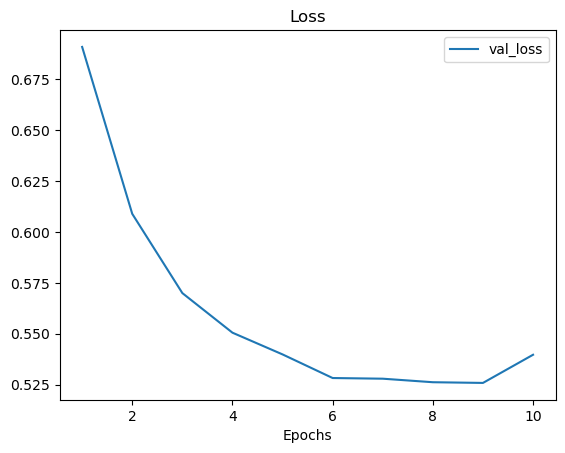

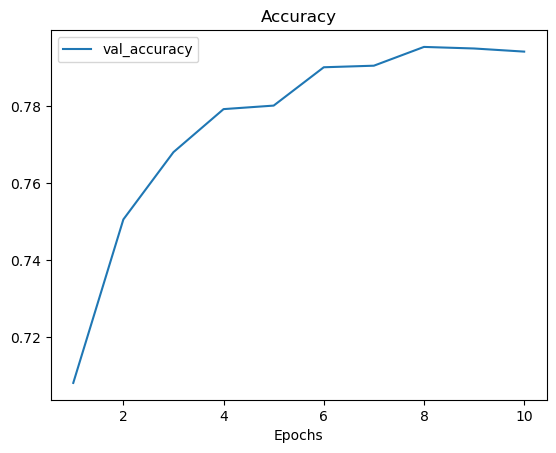

In [124]:
model_history(str0,10)

Based on the graph above, the ideal epoch to select for model 0 is epoch 8.

308/308 [==============================] - 29s 90ms/step - loss: 0.4811 - accuracy: 0.8112


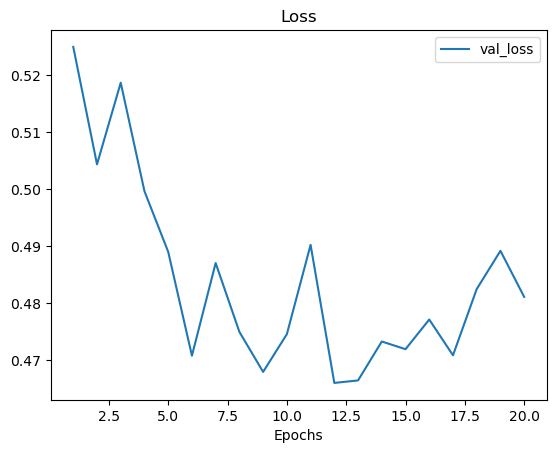

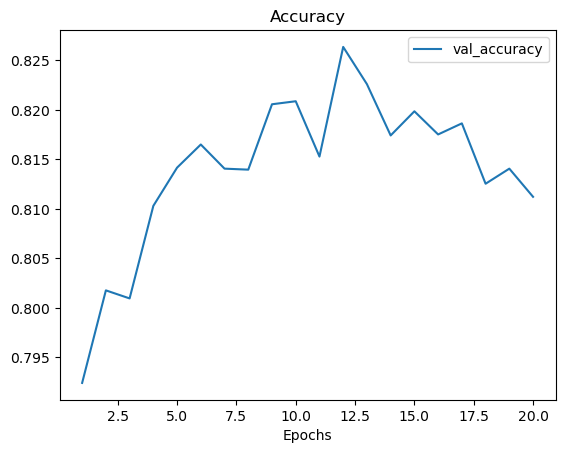

In [125]:
model_history(str1,20)

For model 1, the best epoch is 12.

308/308 [==============================] - 2689s 9s/step - loss: 0.4741 - accuracy: 0.8236


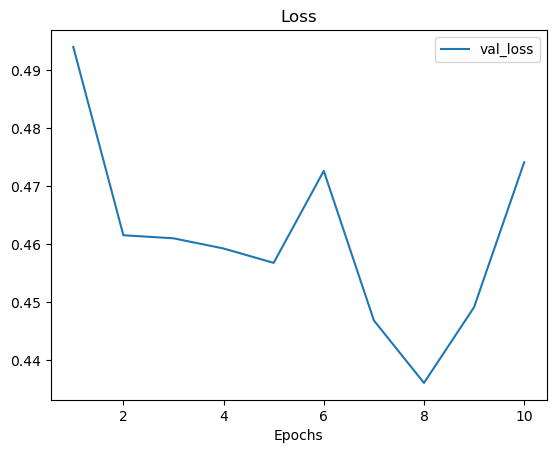

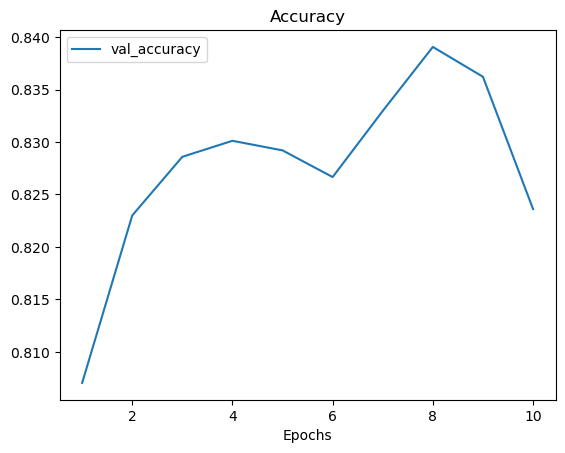

In [126]:
model_history(str2,10)

For model 2, the best epoch is 8.

Now it's time to test the selected models on the test data.

In [14]:
model_0 = tf.keras.models.load_model("initial_model_8")
model_1 = tf.keras.models.load_model("attention_model_12")
model_2 = tf.keras.models.load_model("esim_model_8")

In [15]:
model_0.evaluate(test_dataset)

307/307 [==============================] - 12s 37ms/step - loss: 0.5302 - accuracy: 0.7913


[0.5301810503005981, 0.7913273572921753]

In [16]:
model_1.evaluate(test_dataset)

307/307 [==============================] - 3s 10ms/step - loss: 0.4739 - accuracy: 0.8201


[0.47392427921295166, 0.8201343417167664]

In [17]:
model_2.evaluate(test_dataset)

307/307 [==============================] - 155s 495ms/step - loss: 0.4492 - accuracy: 0.8270


[0.4492034316062927, 0.8269544243812561]

As expected, the ESIM model exhibits the best performance.

Finally, I will examine a few examples of sentences where different models succeeded and failed to output the correct prediction.

In [59]:
df_test.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, contradiction, contradiction, neutra...",2677109430.jpg#1,neutral,2677109430.jpg#1r1n,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,The church has cracks in the ceiling.,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...
1,"[entailment, entailment, entailment, neutral, ...",2677109430.jpg#1,entailment,2677109430.jpg#1r1e,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,The church is filled with song.,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...
2,"[contradiction, contradiction, contradiction, ...",2677109430.jpg#1,contradiction,2677109430.jpg#1r1c,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,A choir singing at a baseball game.,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...
3,"[neutral, neutral, neutral, neutral, neutral]",6160193920.jpg#4,neutral,6160193920.jpg#4r1n,"A woman with a green headscarf, blue shirt and...",( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,The woman is young.,( ( The woman ) ( ( is young ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...
4,"[entailment, entailment, contradiction, entail...",6160193920.jpg#4,entailment,6160193920.jpg#4r1e,"A woman with a green headscarf, blue shirt and...",( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,The woman is very happy.,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...


In [31]:
len(df_test)

9824

In [20]:
labels = df_test['gold_label']
labels = labels.apply(lambda x: 2 if x=="entailment" else 1 if x=="neutral" else 0)
sentences = df_test[['sentence1','sentence2']]

In [21]:
sentences.iloc[0,:].values

array(['This church choir sings to the masses as they sing joyous songs from the book at a church.',
       'The church has cracks in the ceiling.'], dtype=object)

In [22]:
model_0_preds = np.argmax(model_0.predict(sentences.values),axis=1)
model_1_preds = np.argmax(model_1.predict(sentences.values),axis=1)
model_2_preds = np.argmax(model_2.predict(sentences.values),axis=1)

307/307 [==============================] - 111s 352ms/step


In [23]:
model_0_series = pd.Series(model_0_preds)
model_1_series = pd.Series(model_1_preds)
model_2_series = pd.Series(model_2_preds)

In [32]:
model_0_series

0       0
1       0
2       0
3       1
4       1
       ..
9819    0
9820    2
9821    0
9822    2
9823    1
Length: 9824, dtype: int64

In [35]:
labels.reset_index().loc[:,'gold_label']

0       1
1       2
2       0
3       1
4       2
       ..
9819    0
9820    2
9821    0
9822    2
9823    1
Name: gold_label, Length: 9824, dtype: int64

In [36]:
df = pd.concat([model_0_series,model_1_series,model_2_series,labels.reset_index().loc[:,'gold_label']],axis=1)

Here, I choose a random pair of sentences that the models all correctly predicted.

In [54]:
df_all = df[(df[0] == df['gold_label']) & (df[1] == df['gold_label']) & (df[2] == df['gold_label'])]

In [60]:
index = df_all.sample().index.values[0]

print(df_all.loc[index,:])
print(sentences.loc[index,:].values)

0             2
1             2
2             2
gold_label    2
Name: 2503, dtype: int64
['A runner poses for a picture with friends in a parking lot.'
 'The runner is posing for a picture.']


Here, I choose a random pair of sentences that none of the models correctly predicted.

In [57]:
df_none = df[(df[0] != df['gold_label']) & (df[1] != df['gold_label']) & (df[2] != df['gold_label'])]

In [61]:
index = df_none.sample().index.values[0]

print(df_none.loc[index,:])
print(sentences.loc[index,:].values)

0             0
1             0
2             0
gold_label    2
Name: 8377, dtype: int64
['Two brown and white dogs running on a grassy but brown fenced yard.'
 'Canines traverse a sealed expanse.']


Here, I choose a random pair of sentences that only the last two models correctly predicted.

In [62]:
df_first_wrong = df[(df[0] != df['gold_label']) & (df[1] == df['gold_label']) & (df[2] == df['gold_label'])]

In [65]:
index = df_first_wrong.sample().index.values[0]

print(df_first_wrong.loc[index,:])
print(sentences.loc[index,:].values)

0             2
1             0
2             0
gold_label    0
Name: 6343, dtype: int64
['Naked children play on the muddy riverbank.'
 'THE RIVERBANK STAYED CLEAN EVERYDAY']


Here, I choose a random pair of sentences that only the last model correctly predicted.

In [66]:
df_last_correct = df[(df[0] != df['gold_label']) & (df[1] != df['gold_label']) & (df[2] == df['gold_label'])]

In [71]:
index = df_last_correct.sample().index.values[0]

print(df_last_correct.loc[index,:])
print(sentences.loc[index,:].values)

0             0
1             1
2             2
gold_label    2
Name: 2721, dtype: int64
['A yellow race car sliding through a corner as spectators watch.'
 'A racecar is being watched.']


In conclusion, the ESIM model produced the best performance in terms of both loss and accuracy, followed by the attention model, followed by the baseline. With additional hyperparameter tweaking and more epochs, the second and third models have the potential to perform noticeably better, but under the time constraints presented here, they still illustrated the value of more complex models in maximizing performance for this task.